In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import math

In [90]:
def log_choose(x, y):
    return math.lgamma(x + 1) - math.lgamma(y + 1) * math.lgamma(x - y + 1)

In [39]:
count_files = glob("fish_quant_analysis/*.csv")

In [56]:
count_files[0]

'fish_quant_analysis/counts_16h_primary.csv'

In [64]:
counts =  pd.read_csv(count_files[1])
counts_spots = counts.query('type in ["Mature","Nascent"]').groupby(['cell','frame']).agg({'count': 'sum'})
counts_no_spots = counts.query('type in ["No Spots"]')
count_distribution = counts_spots['count'].value_counts().sort_index()
count_distribution[0] = len(counts_no_spots)
count_distribution = count_distribution.sort_index()

In [23]:
def P(w,p,r,n):
    """
    Calculate the probability of a given weight and price.
    """
    if n==0:
        return w+(1-w)*(1-p)**r
    else:
        return (1-w)*choose(n+r-1,n) * p**n * (1-p)**r

In [ ]:
def log_P(w,p,r,n):
    """
    Calculate the log probability of a given weight and price.
    """
    if n==0:
        return math.log(w+(1-w)*(1-p)**r)
    else:
        return math.log(1-w) +\
            log_choose(n+r-1,n) +\
            n*math.log(p) +\
            r*math.log(1-p)

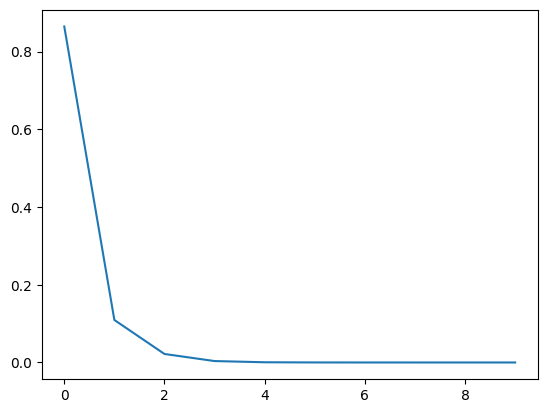

In [32]:
plt.plot([P(.5,0.1,3,n) for n in np.arange(10)], label="w=1,p=0.1,r=3")

In [94]:
def log_likelihood(w, p, r):
    """
    Calculate the log likelihood of a given weight and price.
    """
    result = 0
    for n in count_distribution.index:
        result += count_distribution[n] * log_P(w, p, r, n)
    return result

In [96]:
import emcee
import corner

# Define the log prior to constrain parameters to valid ranges
def log_prior(params):
    w, p, r = params
    if 0 <= w <= 1 and 0 <= p <= 1 and r > 0:
        return 0.0  # Uniform prior within constraints
    return -np.inf  # Zero probability outside constraints

# Define the log posterior (log prior + log likelihood)
def log_posterior(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params[0], params[1], params[2])

# Set up the MCMC sampler
ndim = 3  # number of parameters (w, p, r)
nwalkers = 32  # number of MCMC walkers
nburn = 1000  # number of burn-in steps
nsteps = 5000  # number of MCMC steps after burn-in

# Start the walkers in a small ball around the optimized values
pos = np.array([w_opt, p_opt, r_opt]) + 1e-4 * np.random.randn(nwalkers, ndim)

# Initialize and run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(pos, nburn + nsteps, progress=True)

# Discard burn-in samples and flatten the chain
samples = sampler.get_chain(discard=nburn, flat=True)

# Create corner plot to visualize posterior distributions
fig = corner.corner(samples, labels=["w", "p", "r"], 
                    truths=[w_opt, p_opt, r_opt],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True)

# Calculate mean and standard deviation for each parameter
w_mcmc, p_mcmc, r_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                           zip(*np.percentile(samples, [16, 50, 84], axis=0)))

print(f"w = {w_mcmc[0]:.4f} +{w_mcmc[1]:.4f} -{w_mcmc[2]:.4f}")
print(f"p = {p_mcmc[0]:.4f} +{p_mcmc[1]:.4f} -{p_mcmc[2]:.4f}")
print(f"r = {r_mcmc[0]:.4f} +{r_mcmc[1]:.4f} -{r_mcmc[2]:.4f}")

# Plot the posterior traces to check for convergence
plt.figure(figsize=(12, 8))
labels = ["w", "p", "r"]
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    samples_chain = sampler.get_chain()
    plt.plot(samples_chain[:, :, i], alpha=0.3)
    plt.ylabel(labels[i])
    if i == ndim-1:
        plt.xlabel("Step Number")
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'emcee'

In [ ]:
!pip install 

(array([148.,  22.,   4.,   3.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

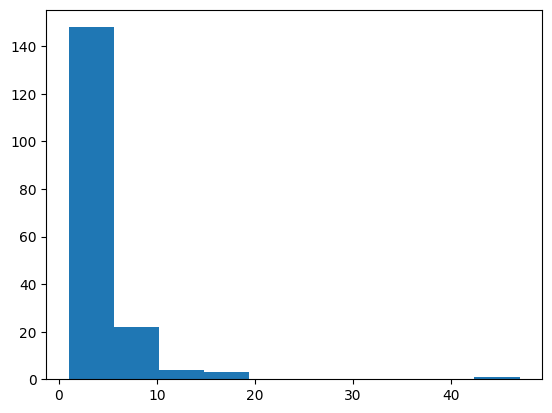

In [38]:
# Create a counter for the 'count' column values
count_distribution = counts['count'].value_counts().sort_index()
plt.hist(count_distribution)